In [12]:
"""
Hard Hat / PPE Detection - Inference and Prediction
===================================================
This notebook performs inference on test images using the trained PPE detection model.
- Loads the best trained model
- Runs predictions on test set
- Visualizes results with color-coded bounding boxes
- Provides statistics and analysis
"""

from pathlib import Path
import os
import torch
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import yaml

%matplotlib inline

# Paths
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / 'data'
DATA_TEST = DATA_DIR / 'test' / 'images'
DATA_YAML = DATA_DIR / 'data.yaml'
RUNS_DIR = PROJECT_ROOT / 'runs' / 'detect'

# Find the best trained model
PPE_MODEL_PATH = None

# Check for phase2 model first (most recent)
phase2_model = RUNS_DIR / 'ppe_detection_phase2' / 'weights' / 'best.pt'
phase1_model = RUNS_DIR / 'ppe_detection_phase1' / 'weights' / 'best.pt'

if phase2_model.exists():
    PPE_MODEL_PATH = phase2_model
    print(f"✅ Found Phase 2 model: {PPE_MODEL_PATH}")
elif phase1_model.exists():
    PPE_MODEL_PATH = phase1_model
    print(f"✅ Found Phase 1 model: {PPE_MODEL_PATH}")
else:
    # Search for any PPE detection model
    if RUNS_DIR.exists():
        train_dirs = sorted([d for d in RUNS_DIR.glob('*') if d.is_dir()], 
                          key=lambda x: x.stat().st_mtime, reverse=True)
        for train_dir in train_dirs:
            if 'ppe' in train_dir.name.lower():
                candidate = train_dir / 'weights' / 'best.pt'
                if candidate.exists():
                    PPE_MODEL_PATH = candidate
                    print(f"✅ Found model: {PPE_MODEL_PATH}")
                    break

if PPE_MODEL_PATH is None or not PPE_MODEL_PATH.exists():
    print("⚠️  Trained model not found. Please run training notebook first.")
    print(f"   Expected location: {phase2_model} or {phase1_model}")

# Load dataset config for class names
if DATA_YAML.exists():
    with open(DATA_YAML, 'r') as f:
        config = yaml.safe_load(f)
    class_names = config.get('names', ['head', 'helmet', 'person'])
    print(f"\nClasses: {class_names}")
else:
    class_names = ['head', 'helmet', 'person']
    print(f"\n⚠️  data.yaml not found, using default classes: {class_names}")

# Color mapping for classes
class_colors = {
    'head': 'red',
    'helmet': 'lime',
    'person': 'cyan'
}

# Check GPU
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"\n🚀 Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# Load model
if PPE_MODEL_PATH and PPE_MODEL_PATH.exists():
    print(f"\n📦 Loading model: {PPE_MODEL_PATH}")
    model = YOLO(str(PPE_MODEL_PATH))
    print("✅ Model loaded successfully")
else:
    print("\n⚠️  Model not found. Cannot proceed with predictions.")
    model = None


✅ Found Phase 2 model: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\ppe_detection_phase2\weights\best.pt

Classes: ['head', 'helmet', 'person']

🚀 Using device: GPU
   GPU: NVIDIA GeForce RTX 3060 Laptop GPU

📦 Loading model: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\ppe_detection_phase2\weights\best.pt
✅ Model loaded successfully


In [13]:
# GPU Performance Monitoring and Analysis
# ============================================
# This cell monitors GPU utilization, RAM usage, and compares GPU vs CPU performance

import time
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import psutil
import gc

# Try to import pynvml for GPU monitoring
try:
    import pynvml
    pynvml.nvmlInit()
    GPU_MONITORING_AVAILABLE = True
    print("✅ GPU monitoring (pynvml) available")
except ImportError:
    print("⚠️  pynvml not available. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pynvml", "-q"])
    import pynvml
    pynvml.nvmlInit()
    GPU_MONITORING_AVAILABLE = True
    print("✅ GPU monitoring (pynvml) installed and ready")

# Setup monitoring
class GPUMonitor:
    """Monitor GPU utilization, memory, temperature, and power"""
    
    def __init__(self, device_id=0, interval=0.1):
        self.device_id = device_id
        self.interval = interval
        self.monitoring = False
        self.data = {
            'time': deque(),
            'gpu_util': deque(),
            'gpu_memory_used': deque(),
            'gpu_memory_total': deque(),
            'gpu_temperature': deque(),
            'gpu_power': deque(),
            'ram_used': deque(),
            'ram_total': deque(),
            'cpu_percent': deque()
        }
        self.handle = pynvml.nvmlDeviceGetHandleByIndex(device_id) if GPU_MONITORING_AVAILABLE else None
        
    def get_gpu_stats(self):
        """Get current GPU statistics"""
        if not GPU_MONITORING_AVAILABLE or self.handle is None:
            return None
        
        try:
            # GPU utilization
            util = pynvml.nvmlDeviceGetUtilizationRates(self.handle)
            gpu_util = util.gpu
            
            # Memory info
            mem_info = pynvml.nvmlDeviceGetMemoryInfo(self.handle)
            gpu_mem_used = mem_info.used / (1024**3)  # GB
            gpu_mem_total = mem_info.total / (1024**3)  # GB
            
            # Temperature
            try:
                temp = pynvml.nvmlDeviceGetTemperature(self.handle, pynvml.NVML_TEMPERATURE_GPU)
            except:
                temp = 0
            
            # Power
            try:
                power = pynvml.nvmlDeviceGetPowerUsage(self.handle) / 1000.0  # Watts
            except:
                power = 0
            
            return {
                'gpu_util': gpu_util,
                'gpu_memory_used': gpu_mem_used,
                'gpu_memory_total': gpu_mem_total,
                'gpu_temperature': temp,
                'gpu_power': power
            }
        except Exception as e:
            return None
    
    def get_system_stats(self):
        """Get system RAM and CPU stats"""
        ram = psutil.virtual_memory()
        return {
            'ram_used': ram.used / (1024**3),  # GB
            'ram_total': ram.total / (1024**3),  # GB
            'cpu_percent': psutil.cpu_percent(interval=None)
        }
    
    def monitor_loop(self):
        """Monitoring loop running in background thread"""
        start_time = time.time()
        while self.monitoring:
            current_time = time.time() - start_time
            
            # GPU stats
            gpu_stats = self.get_gpu_stats()
            if gpu_stats:
                self.data['time'].append(current_time)
                self.data['gpu_util'].append(gpu_stats['gpu_util'])
                self.data['gpu_memory_used'].append(gpu_stats['gpu_memory_used'])
                self.data['gpu_memory_total'].append(gpu_stats['gpu_memory_total'])
                self.data['gpu_temperature'].append(gpu_stats['gpu_temperature'])
                self.data['gpu_power'].append(gpu_stats['gpu_power'])
            else:
                self.data['time'].append(current_time)
                self.data['gpu_util'].append(0)
                self.data['gpu_memory_used'].append(0)
                self.data['gpu_memory_total'].append(0)
                self.data['gpu_temperature'].append(0)
                self.data['gpu_power'].append(0)
            
            # System stats
            sys_stats = self.get_system_stats()
            self.data['ram_used'].append(sys_stats['ram_used'])
            self.data['ram_total'].append(sys_stats['ram_total'])
            self.data['cpu_percent'].append(sys_stats['cpu_percent'])
            
            time.sleep(self.interval)
    
    def start(self):
        """Start monitoring"""
        self.monitoring = True
        self.thread = threading.Thread(target=self.monitor_loop, daemon=True)
        self.thread.start()
    
    def stop(self):
        """Stop monitoring"""
        self.monitoring = False
        if hasattr(self, 'thread'):
            self.thread.join(timeout=2)
    
    def get_dataframe(self):
        """Convert monitoring data to DataFrame"""
        return pd.DataFrame({
            'time': list(self.data['time']),
            'gpu_util': list(self.data['gpu_util']),
            'gpu_memory_used': list(self.data['gpu_memory_used']),
            'gpu_memory_total': list(self.data['gpu_memory_total']),
            'gpu_temperature': list(self.data['gpu_temperature']),
            'gpu_power': list(self.data['gpu_power']),
            'ram_used': list(self.data['ram_used']),
            'ram_total': list(self.data['ram_total']),
            'cpu_percent': list(self.data['cpu_percent'])
        })

# Initialize monitor
if torch.cuda.is_available() and GPU_MONITORING_AVAILABLE:
    monitor = GPUMonitor(device_id=0, interval=0.1)
    print(f"✅ GPU Monitor initialized for device 0")
    
    # Get initial GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"   GPU: {gpu_name}")
    print(f"   Total GPU Memory: {gpu_memory:.2f} GB")
else:
    monitor = None
    print("⚠️  GPU monitoring not available (CPU mode or pynvml unavailable)")

print("\n✅ Monitoring utilities ready!")


✅ GPU monitoring (pynvml) available
✅ GPU Monitor initialized for device 0
   GPU: NVIDIA GeForce RTX 3060 Laptop GPU
   Total GPU Memory: 6.00 GB

✅ Monitoring utilities ready!


In [17]:
# GPU vs CPU Performance Comparison with Video Benchmarking
# ============================================================
# This cell runs inference on video using both GPU and CPU to compare performance
# Video benchmarking better highlights GPU advantages for continuous workloads

import cv2

if model is not None:
    # Video path for benchmarking
    # Try multiple possible video locations
    video_paths = [
        r"C:\Users\Omar\Downloads\Busy Traffic On Vietnam Roads Stock Video.mp4",
        PROJECT_ROOT / 'runs' / 'video_out.mp4',
        Path(r"C:\Users\Omar\Downloads\HIGHLIGHTS _ Getafe 0-1 Real Madrid _ LaLiga.mp4"),
    ]
    
    benchmark_video = None
    for vp in video_paths:
        vp_path = Path(vp) if isinstance(vp, str) else vp
        if vp_path.exists() and vp_path.is_file():
            benchmark_video = str(vp_path)
            break
    
    if benchmark_video is None:
        print("⚠️  No video file found for benchmarking")
        print("   Please specify a video path in the code or place a video file in one of these locations:")
        for vp in video_paths:
            print(f"      - {vp}")
        benchmark_results = None
    else:
        print(f"\n🔬 Performance Benchmark: GPU vs CPU (Video Inference)")
        print(f"   Video: {Path(benchmark_video).name}")
        print("=" * 70)
        
        # Open video to get properties
        cap = cv2.VideoCapture(benchmark_video)
        if not cap.isOpened():
            print(f"❌ Error: Could not open video file: {benchmark_video}")
            benchmark_results = None
        else:
            video_fps = cap.get(cv2.CAP_PROP_FPS)
            video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()
            
            print(f"   Resolution: {video_width}x{video_height}")
            print(f"   Original FPS: {video_fps:.2f}")
            print(f"   Total frames: {total_frames}")
            
            # Limit frames for benchmarking (process first N frames or sample)
            MAX_BENCHMARK_FRAMES = 500  # Process 500 frames for benchmarking
            frame_sample = max(1, total_frames // MAX_BENCHMARK_FRAMES) if total_frames > MAX_BENCHMARK_FRAMES else 1
            frames_to_process = min(MAX_BENCHMARK_FRAMES, total_frames)
            
            print(f"   Processing: {frames_to_process} frames (sampling every {frame_sample} frame(s))")
            print("=" * 70)
            
            results_comparison = {}
            
            # ========== GPU Inference with Monitoring ==========
            if torch.cuda.is_available() and monitor is not None:
                print("\n📊 Running GPU inference with monitoring...")
                
                # Clear GPU cache
                torch.cuda.empty_cache()
                gc.collect()
                
                # Start monitoring
                monitor.start()
                time.sleep(0.5)  # Let monitoring stabilize
                
                # Open video
                cap = cv2.VideoCapture(benchmark_video)
                
                # Run inference on GPU
                gpu_times = []
                gpu_start = time.time()
                frame_count = 0
                processed_frames = 0
                
                while processed_frames < frames_to_process:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    
                    # Sample frames
                    if frame_count % frame_sample == 0:
                        frame_start = time.time()
                        result = model.predict(
                            source=frame,
                            imgsz=640,
                            conf=0.25,
                            iou=0.45,
                            device=0,  # GPU
                            half=True,  # FP16
                            verbose=False,
                            save=False
                        )
                        frame_time = time.time() - frame_start
                        gpu_times.append(frame_time)
                        processed_frames += 1
                        
                        if processed_frames % 50 == 0:
                            print(f"   Processed {processed_frames}/{frames_to_process} frames...")
                    
                    frame_count += 1
                
                cap.release()
                gpu_total_time = time.time() - gpu_start
                
                # Stop monitoring
                time.sleep(0.5)  # Capture final metrics
                monitor.stop()
                
                # Get monitoring data
                gpu_monitor_df = monitor.get_dataframe()
                
                # Calculate averages
                avg_gpu_time = np.mean(gpu_times) if len(gpu_times) > 0 else 0
                fps_gpu = 1.0 / avg_gpu_time if avg_gpu_time > 0 else 0
                
                results_comparison['GPU'] = {
                    'total_time': gpu_total_time,
                    'avg_time_per_frame': avg_gpu_time,
                    'fps': fps_gpu,
                    'times': gpu_times,
                    'frames_processed': processed_frames,
                    'monitor_data': gpu_monitor_df,
                    'device': 'GPU (CUDA)'
                }
                
                print(f"   ✅ GPU inference complete!")
                print(f"      Total time: {gpu_total_time:.2f}s")
                print(f"      Frames processed: {processed_frames}")
                print(f"      Avg time/frame: {avg_gpu_time*1000:.2f}ms")
                print(f"      FPS: {fps_gpu:.2f}")
                
                # GPU memory stats
                if len(gpu_monitor_df) > 0:
                    avg_gpu_mem = gpu_monitor_df['gpu_memory_used'].mean()
                    max_gpu_mem = gpu_monitor_df['gpu_memory_used'].max()
                    avg_gpu_util = gpu_monitor_df['gpu_util'].mean()
                    print(f"      Avg GPU Memory: {avg_gpu_mem:.2f} GB")
                    print(f"      Max GPU Memory: {max_gpu_mem:.2f} GB")
                    print(f"      Avg GPU Utilization: {avg_gpu_util:.1f}%")
            
            # ========== CPU Inference ==========
            print("\n📊 Running CPU inference...")
            
            # Clear caches
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Open video
            cap = cv2.VideoCapture(benchmark_video)
            
            # Run inference on CPU
            cpu_times = []
            cpu_start = time.time()
            frame_count = 0
            processed_frames = 0
            
            while processed_frames < frames_to_process:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Sample frames (same as GPU)
                if frame_count % frame_sample == 0:
                    frame_start = time.time()
                    result = model.predict(
                        source=frame,
                        imgsz=640,
                        conf=0.25,
                        iou=0.45,
                        device='cpu',  # CPU
                        half=False,  # No FP16 on CPU
                        verbose=False,
                        save=False
                    )
                    frame_time = time.time() - frame_start
                    cpu_times.append(frame_time)
                    processed_frames += 1
                    
                    if processed_frames % 50 == 0:
                        print(f"   Processed {processed_frames}/{frames_to_process} frames...")
                
                frame_count += 1
            
            cap.release()
            cpu_total_time = time.time() - cpu_start
            
            # Calculate averages
            avg_cpu_time = np.mean(cpu_times) if len(cpu_times) > 0 else 0
            fps_cpu = 1.0 / avg_cpu_time if avg_cpu_time > 0 else 0
            
            results_comparison['CPU'] = {
                'total_time': cpu_total_time,
                'avg_time_per_frame': avg_cpu_time,
                'fps': fps_cpu,
                'times': cpu_times,
                'frames_processed': processed_frames,
                'device': 'CPU'
            }
            
            print(f"   ✅ CPU inference complete!")
            print(f"      Total time: {cpu_total_time:.2f}s")
            print(f"      Frames processed: {processed_frames}")
            print(f"      Avg time/frame: {avg_cpu_time*1000:.2f}ms")
            print(f"      FPS: {fps_cpu:.2f}")
            
            # ========== Calculate Speedup ==========
            if 'GPU' in results_comparison and 'CPU' in results_comparison:
                speedup = cpu_total_time / gpu_total_time
                time_saved = cpu_total_time - gpu_total_time
                fps_speedup = fps_gpu / fps_cpu if fps_cpu > 0 else 0
                
                print("\n" + "=" * 70)
                print("📈 PERFORMANCE COMPARISON SUMMARY")
                print("=" * 70)
                print(f"\n🚀 Speedup: {speedup:.2f}x faster on GPU")
                print(f"⏱️  Time saved: {time_saved:.2f}s ({time_saved/cpu_total_time*100:.1f}% reduction)")
                print(f"📊 FPS Improvement: {fps_speedup:.2f}x ({fps_cpu:.2f} → {fps_gpu:.2f} FPS)")
                print(f"\n📊 Detailed Metrics:")
                print(f"   {'Metric':<30} {'CPU':<18} {'GPU':<18} {'Improvement':<15}")
                print(f"   {'-'*81}")
                print(f"   {'Total Time (s)':<30} {cpu_total_time:<18.2f} {gpu_total_time:<18.2f} {speedup:.2f}x")
                print(f"   {'Avg Time/Frame (ms)':<30} {avg_cpu_time*1000:<18.2f} {avg_gpu_time*1000:<18.2f} {speedup:.2f}x")
                print(f"   {'FPS':<30} {fps_cpu:<18.2f} {fps_gpu:<18.2f} {fps_speedup:.2f}x")
                print(f"   {'Frames Processed':<30} {processed_frames:<18} {processed_frames:<18} {'Same':<15}")
                print("=" * 70)
            
            # Store results for visualization
            benchmark_results = results_comparison
            
else:
    print("⚠️  Model not loaded. Cannot run benchmark.")
    benchmark_results = None



🔬 Performance Benchmark: GPU vs CPU (Video Inference)
   Video: Busy Traffic On Vietnam Roads Stock Video.mp4
   Resolution: 1280x720
   Original FPS: 29.97
   Total frames: 460
   Processing: 460 frames (sampling every 1 frame(s))

📊 Running GPU inference with monitoring...
   Processed 50/460 frames...
   Processed 100/460 frames...
   Processed 150/460 frames...
   Processed 200/460 frames...
   Processed 250/460 frames...
   Processed 300/460 frames...
   Processed 350/460 frames...
   Processed 400/460 frames...
   Processed 450/460 frames...
   ✅ GPU inference complete!
      Total time: 17.05s
      Frames processed: 455
      Avg time/frame: 34.49ms
      FPS: 29.00
      Avg GPU Memory: 0.34 GB
      Max GPU Memory: 0.34 GB
      Avg GPU Utilization: 13.7%

📊 Running CPU inference...
   Processed 50/460 frames...
   Processed 100/460 frames...
   Processed 150/460 frames...
   Processed 200/460 frames...
   Processed 250/460 frames...
   Processed 300/460 frames...
   Process


📊 Generating comprehensive performance visualizations...


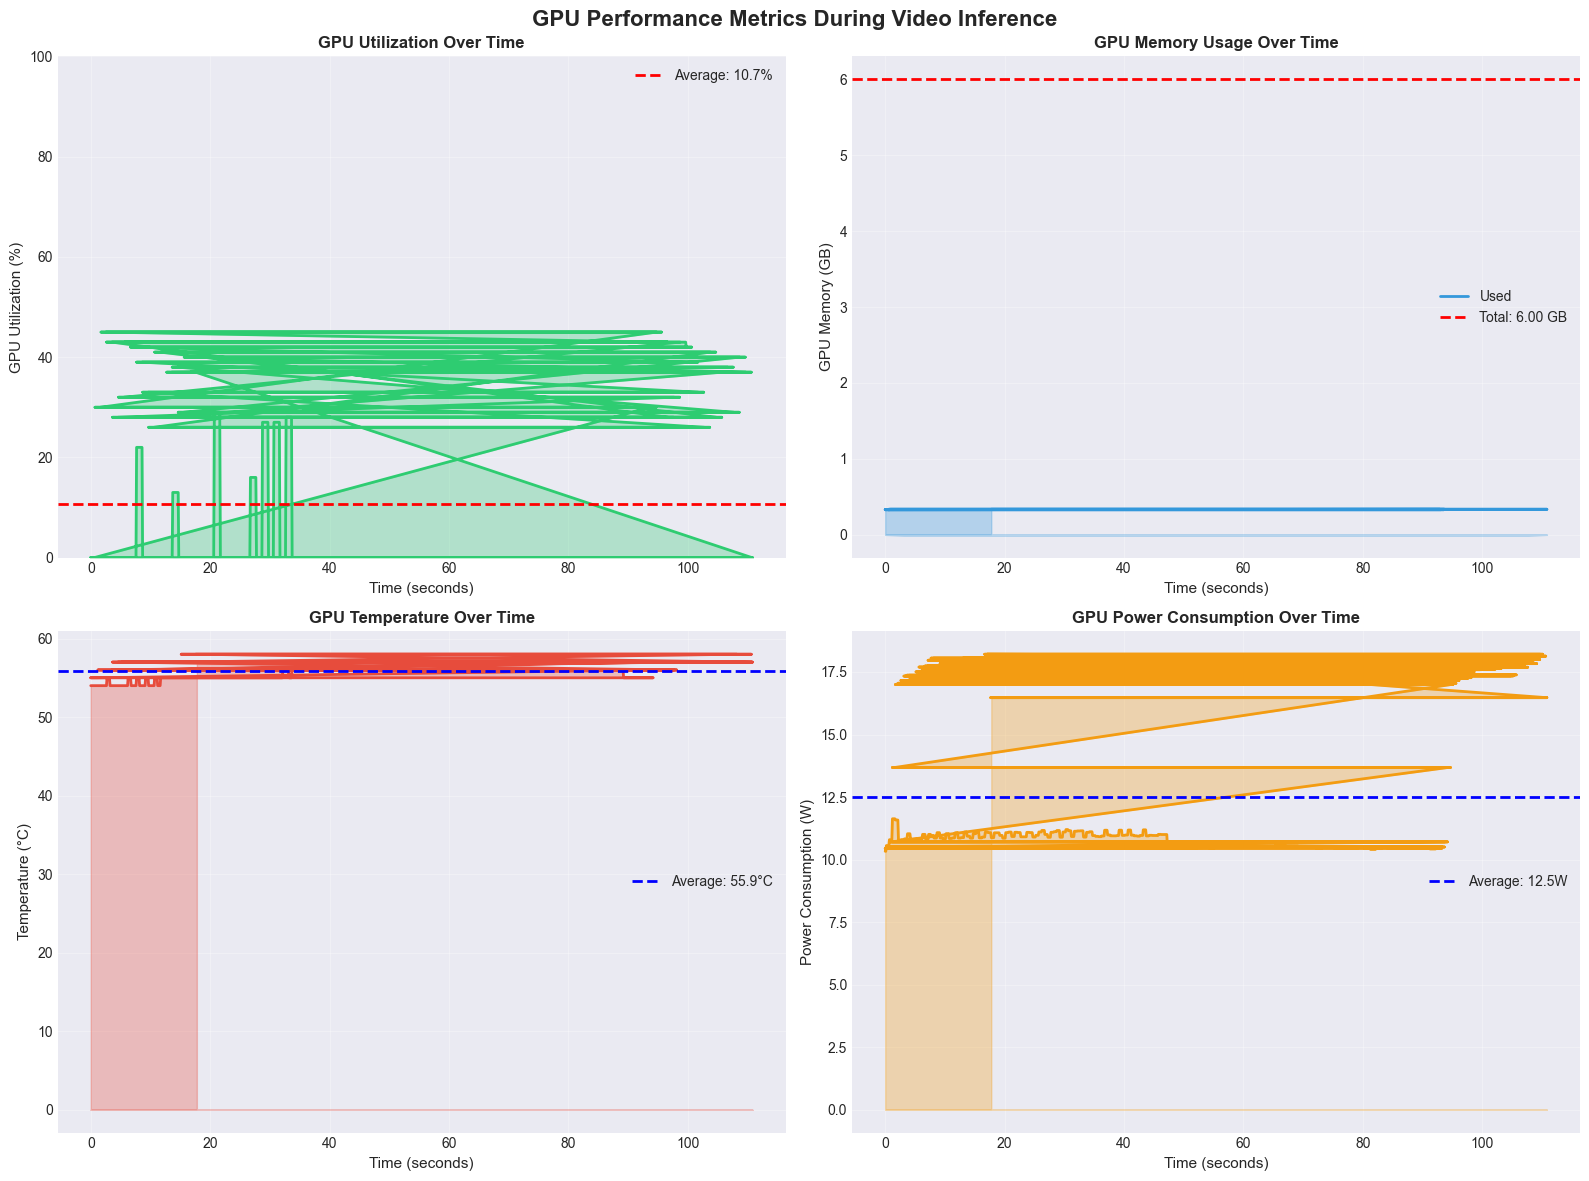

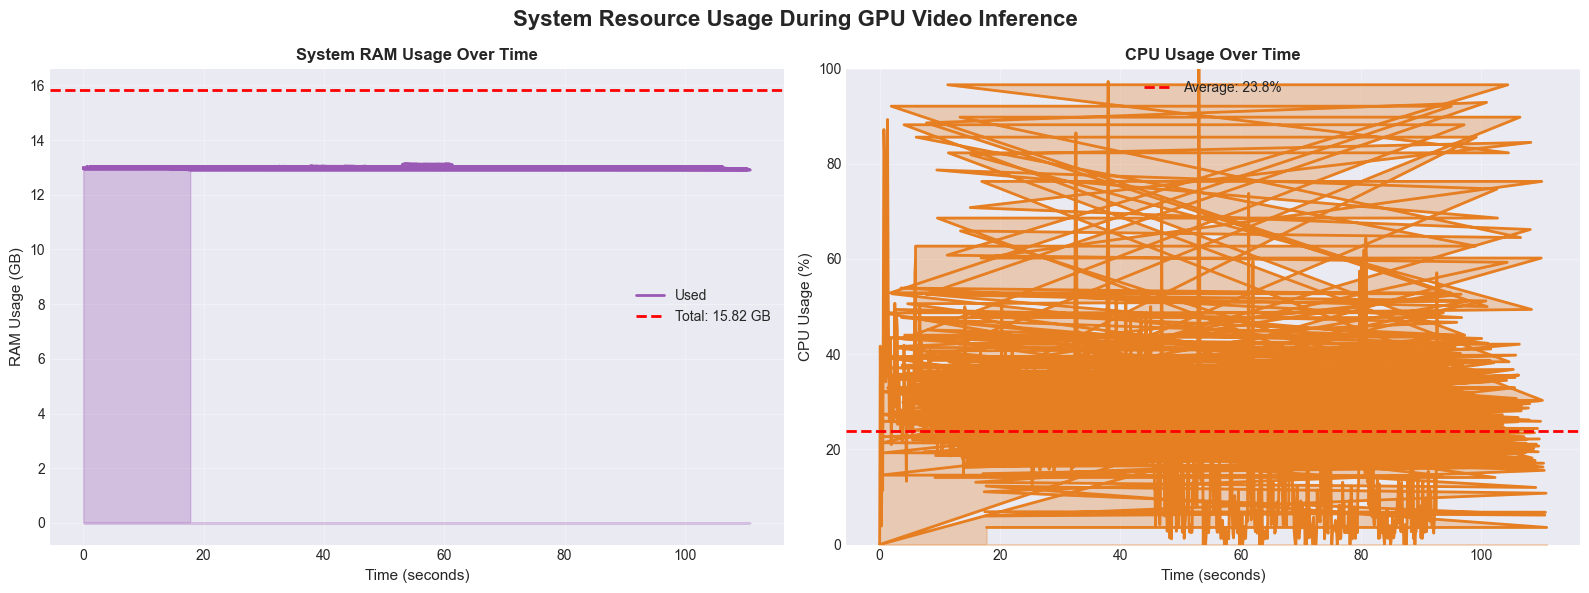

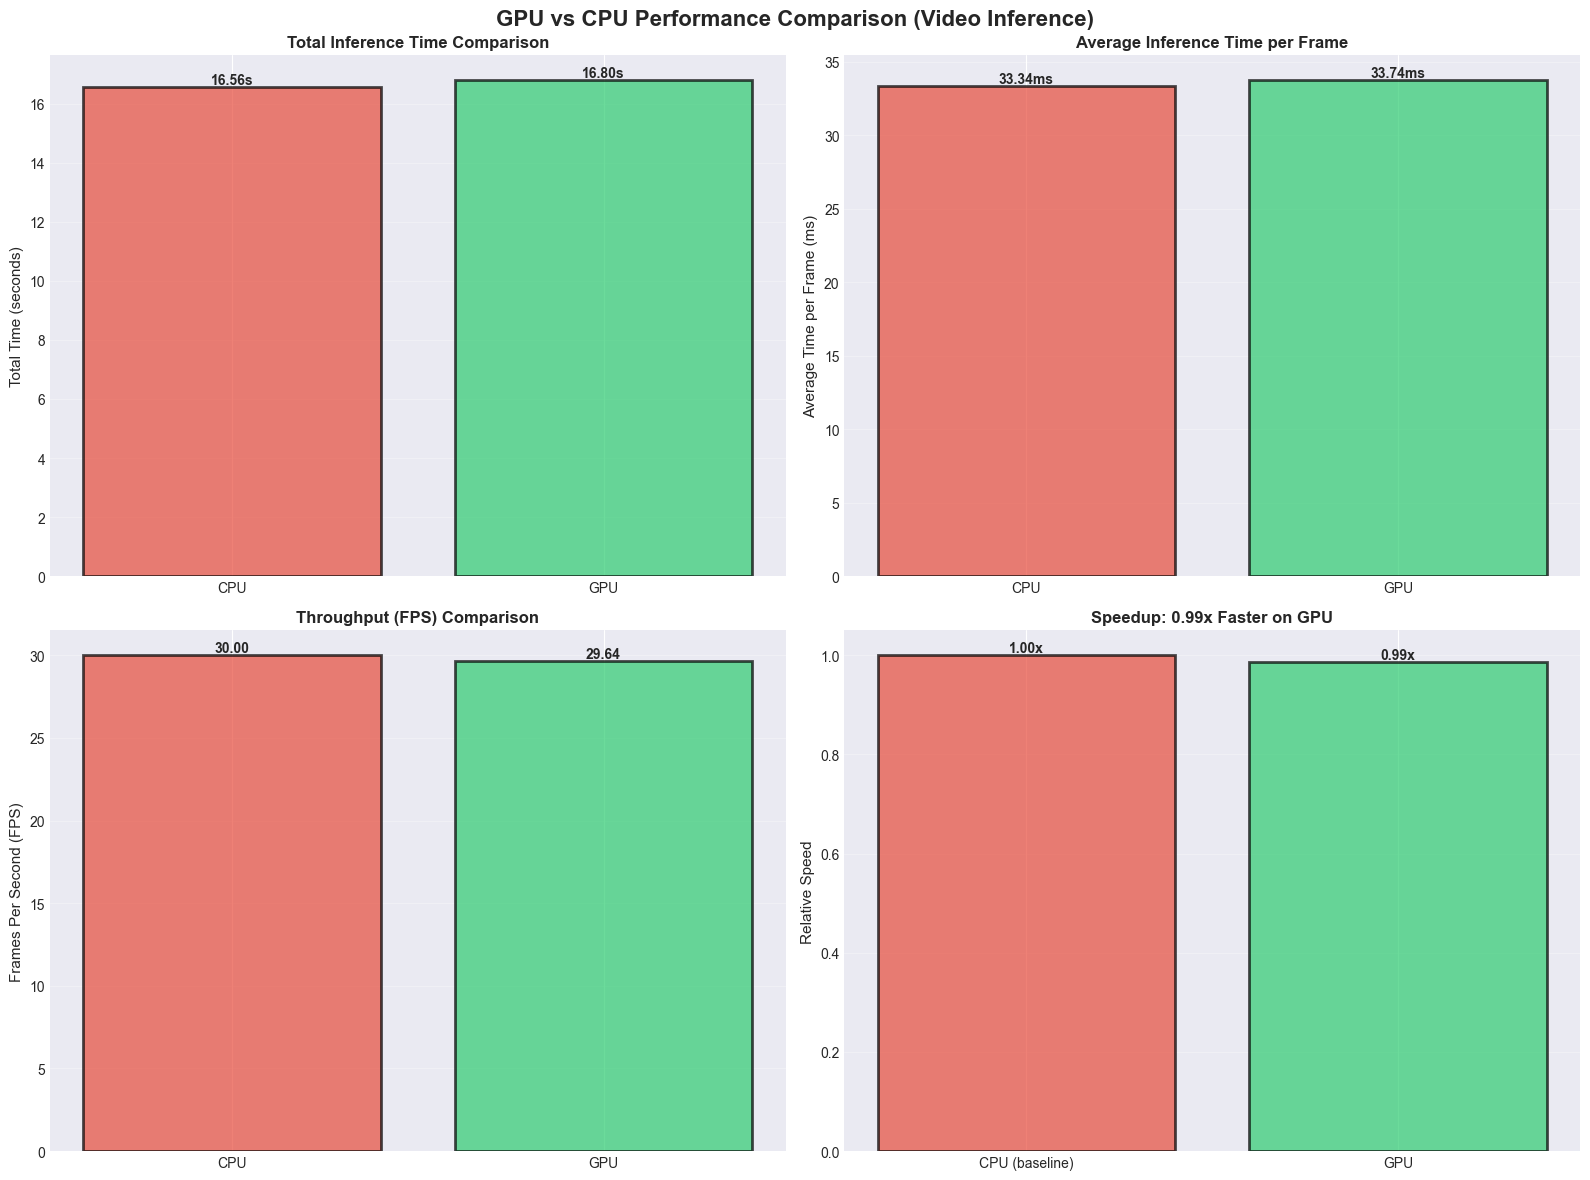

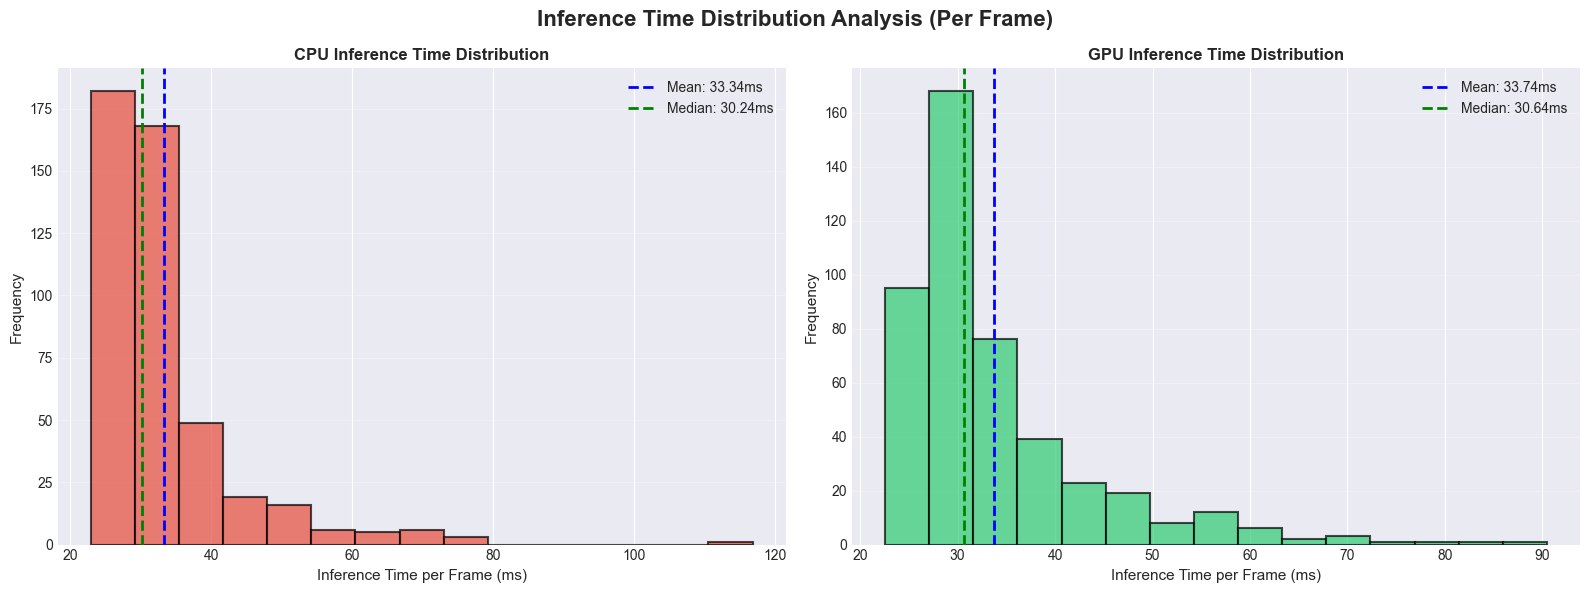

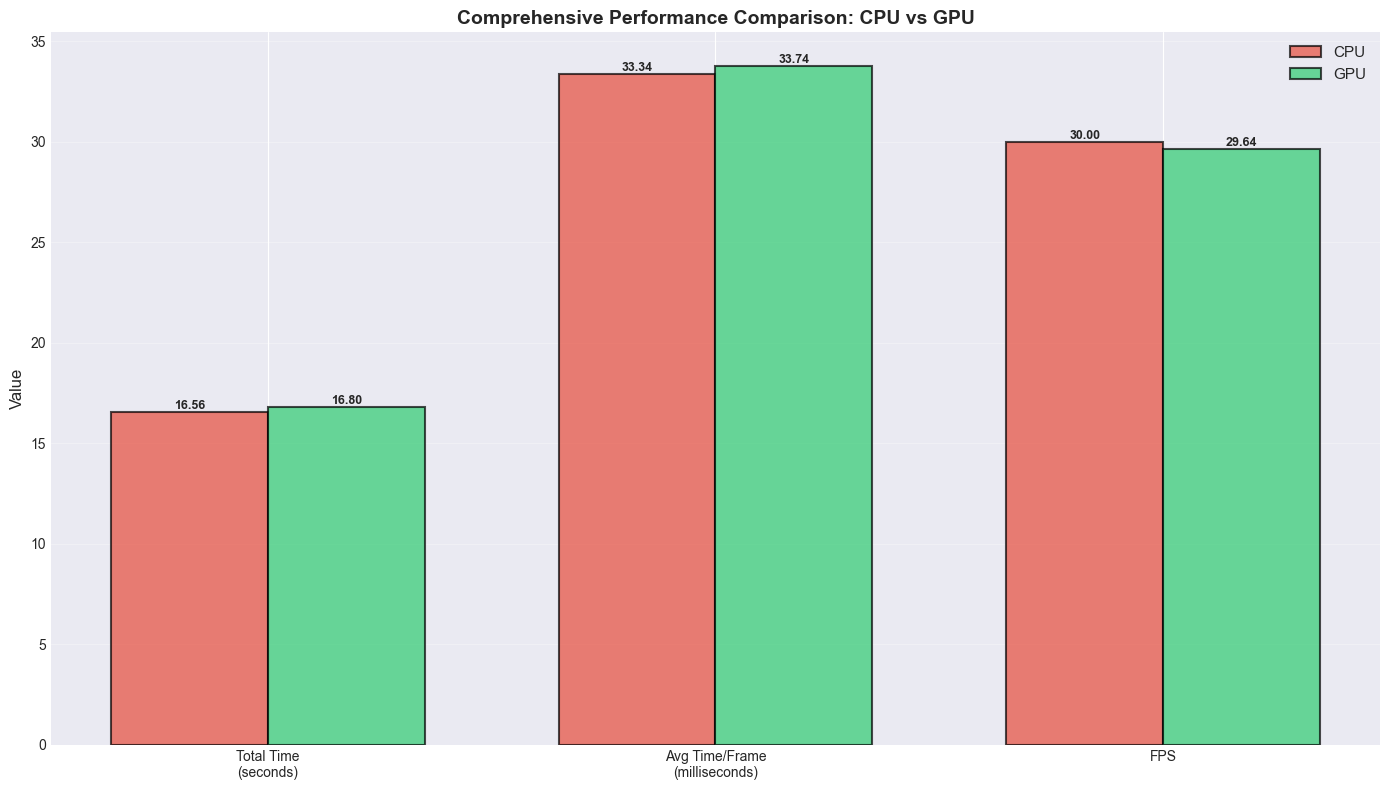


✅ All visualizations generated successfully!


In [16]:
# Comprehensive Performance Visualization
# ========================================
# Create detailed charts for GPU utilization, RAM, performance metrics, and comparisons

if 'benchmark_results' in globals() and benchmark_results is not None:
    print("\n📊 Generating comprehensive performance visualizations...")
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # ========== Figure 1: GPU Utilization and Memory ==========
    if 'GPU' in benchmark_results and benchmark_results['GPU'].get('monitor_data') is not None:
        gpu_df = benchmark_results['GPU']['monitor_data']
        
        if len(gpu_df) > 0:
            fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
            fig1.suptitle('GPU Performance Metrics During Video Inference', fontsize=16, fontweight='bold')
            
            # GPU Utilization
            axes1[0, 0].plot(gpu_df['time'], gpu_df['gpu_util'], linewidth=2, color='#2ecc71')
            axes1[0, 0].fill_between(gpu_df['time'], gpu_df['gpu_util'], alpha=0.3, color='#2ecc71')
            axes1[0, 0].set_xlabel('Time (seconds)', fontsize=11)
            axes1[0, 0].set_ylabel('GPU Utilization (%)', fontsize=11)
            axes1[0, 0].set_title('GPU Utilization Over Time', fontsize=12, fontweight='bold')
            axes1[0, 0].grid(True, alpha=0.3)
            axes1[0, 0].set_ylim([0, 100])
            avg_util = gpu_df['gpu_util'].mean()
            axes1[0, 0].axhline(y=avg_util, color='r', linestyle='--', linewidth=2, 
                               label=f'Average: {avg_util:.1f}%')
            axes1[0, 0].legend()
            
            # GPU Memory Usage
            axes1[0, 1].plot(gpu_df['time'], gpu_df['gpu_memory_used'], linewidth=2, color='#3498db', label='Used')
            if 'gpu_memory_total' in gpu_df.columns:
                total_mem = gpu_df['gpu_memory_total'].iloc[0] if len(gpu_df) > 0 else 0
                axes1[0, 1].axhline(y=total_mem, color='r', linestyle='--', linewidth=2, 
                                   label=f'Total: {total_mem:.2f} GB')
            axes1[0, 1].fill_between(gpu_df['time'], gpu_df['gpu_memory_used'], alpha=0.3, color='#3498db')
            axes1[0, 1].set_xlabel('Time (seconds)', fontsize=11)
            axes1[0, 1].set_ylabel('GPU Memory (GB)', fontsize=11)
            axes1[0, 1].set_title('GPU Memory Usage Over Time', fontsize=12, fontweight='bold')
            axes1[0, 1].grid(True, alpha=0.3)
            axes1[0, 1].legend()
            
            # GPU Temperature
            if 'gpu_temperature' in gpu_df.columns and gpu_df['gpu_temperature'].sum() > 0:
                axes1[1, 0].plot(gpu_df['time'], gpu_df['gpu_temperature'], linewidth=2, color='#e74c3c')
                axes1[1, 0].fill_between(gpu_df['time'], gpu_df['gpu_temperature'], alpha=0.3, color='#e74c3c')
                axes1[1, 0].set_xlabel('Time (seconds)', fontsize=11)
                axes1[1, 0].set_ylabel('Temperature (°C)', fontsize=11)
                axes1[1, 0].set_title('GPU Temperature Over Time', fontsize=12, fontweight='bold')
                axes1[1, 0].grid(True, alpha=0.3)
                avg_temp = gpu_df['gpu_temperature'].mean()
                if avg_temp > 0:
                    axes1[1, 0].axhline(y=avg_temp, color='b', linestyle='--', linewidth=2, 
                                       label=f'Average: {avg_temp:.1f}°C')
                    axes1[1, 0].legend()
            else:
                axes1[1, 0].text(0.5, 0.5, 'Temperature data\nnot available', 
                               ha='center', va='center', fontsize=12)
                axes1[1, 0].set_title('GPU Temperature Over Time', fontsize=12, fontweight='bold')
            
            # GPU Power Consumption
            if 'gpu_power' in gpu_df.columns and gpu_df['gpu_power'].sum() > 0:
                axes1[1, 1].plot(gpu_df['time'], gpu_df['gpu_power'], linewidth=2, color='#f39c12')
                axes1[1, 1].fill_between(gpu_df['time'], gpu_df['gpu_power'], alpha=0.3, color='#f39c12')
                axes1[1, 1].set_xlabel('Time (seconds)', fontsize=11)
                axes1[1, 1].set_ylabel('Power Consumption (W)', fontsize=11)
                axes1[1, 1].set_title('GPU Power Consumption Over Time', fontsize=12, fontweight='bold')
                axes1[1, 1].grid(True, alpha=0.3)
                avg_power = gpu_df['gpu_power'].mean()
                if avg_power > 0:
                    axes1[1, 1].axhline(y=avg_power, color='b', linestyle='--', linewidth=2, 
                                        label=f'Average: {avg_power:.1f}W')
                    axes1[1, 1].legend()
            else:
                axes1[1, 1].text(0.5, 0.5, 'Power data\nnot available', 
                               ha='center', va='center', fontsize=12)
                axes1[1, 1].set_title('GPU Power Consumption Over Time', fontsize=12, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
    
    # ========== Figure 2: System RAM and CPU Usage ==========
    if 'GPU' in benchmark_results and benchmark_results['GPU'].get('monitor_data') is not None:
        gpu_df = benchmark_results['GPU']['monitor_data']
        
        if len(gpu_df) > 0 and 'ram_used' in gpu_df.columns:
            fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
            fig2.suptitle('System Resource Usage During GPU Video Inference', fontsize=16, fontweight='bold')
            
            # RAM Usage
            axes2[0].plot(gpu_df['time'], gpu_df['ram_used'], linewidth=2, color='#9b59b6', label='Used')
            if 'ram_total' in gpu_df.columns:
                total_ram = gpu_df['ram_total'].iloc[0] if len(gpu_df) > 0 else 0
                axes2[0].axhline(y=total_ram, color='r', linestyle='--', linewidth=2, 
                               label=f'Total: {total_ram:.2f} GB')
            axes2[0].fill_between(gpu_df['time'], gpu_df['ram_used'], alpha=0.3, color='#9b59b6')
            axes2[0].set_xlabel('Time (seconds)', fontsize=11)
            axes2[0].set_ylabel('RAM Usage (GB)', fontsize=11)
            axes2[0].set_title('System RAM Usage Over Time', fontsize=12, fontweight='bold')
            axes2[0].grid(True, alpha=0.3)
            axes2[0].legend()
            
            # CPU Usage
            if 'cpu_percent' in gpu_df.columns:
                axes2[1].plot(gpu_df['time'], gpu_df['cpu_percent'], linewidth=2, color='#e67e22')
                axes2[1].fill_between(gpu_df['time'], gpu_df['cpu_percent'], alpha=0.3, color='#e67e22')
                axes2[1].set_xlabel('Time (seconds)', fontsize=11)
                axes2[1].set_ylabel('CPU Usage (%)', fontsize=11)
                axes2[1].set_title('CPU Usage Over Time', fontsize=12, fontweight='bold')
                axes2[1].grid(True, alpha=0.3)
                axes2[1].set_ylim([0, 100])
                avg_cpu = gpu_df['cpu_percent'].mean()
                axes2[1].axhline(y=avg_cpu, color='r', linestyle='--', linewidth=2, 
                               label=f'Average: {avg_cpu:.1f}%')
                axes2[1].legend()
            
            plt.tight_layout()
            plt.show()
    
    # ========== Figure 3: GPU vs CPU Performance Comparison ==========
    fig3, axes3 = plt.subplots(2, 2, figsize=(16, 12))
    fig3.suptitle('GPU vs CPU Performance Comparison (Video Inference)', fontsize=16, fontweight='bold')
    
    # Bar chart: Total Time
    devices = []
    total_times = []
    if 'CPU' in benchmark_results:
        devices.append('CPU')
        total_times.append(benchmark_results['CPU']['total_time'])
    if 'GPU' in benchmark_results:
        devices.append('GPU')
        total_times.append(benchmark_results['GPU']['total_time'])
    
    if len(devices) > 0:
        colors = ['#e74c3c', '#2ecc71']
        bars1 = axes3[0, 0].bar(devices, total_times, color=colors[:len(devices)], alpha=0.7, edgecolor='black', linewidth=2)
        axes3[0, 0].set_ylabel('Total Time (seconds)', fontsize=11)
        axes3[0, 0].set_title('Total Inference Time Comparison', fontsize=12, fontweight='bold')
        axes3[0, 0].grid(True, alpha=0.3, axis='y')
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            axes3[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Bar chart: Average Time per Frame
        avg_times = []
        if 'CPU' in benchmark_results:
            # Handle both 'avg_time_per_image' (old) and 'avg_time_per_frame' (new)
            avg_time_key = 'avg_time_per_frame' if 'avg_time_per_frame' in benchmark_results['CPU'] else 'avg_time_per_image'
            avg_times.append(benchmark_results['CPU'][avg_time_key] * 1000)  # Convert to ms
        if 'GPU' in benchmark_results:
            avg_time_key = 'avg_time_per_frame' if 'avg_time_per_frame' in benchmark_results['GPU'] else 'avg_time_per_image'
            avg_times.append(benchmark_results['GPU'][avg_time_key] * 1000)  # Convert to ms
        
        bars2 = axes3[0, 1].bar(devices, avg_times, color=colors[:len(devices)], alpha=0.7, edgecolor='black', linewidth=2)
        axes3[0, 1].set_ylabel('Average Time per Frame (ms)', fontsize=11)
        axes3[0, 1].set_title('Average Inference Time per Frame', fontsize=12, fontweight='bold')
        axes3[0, 1].grid(True, alpha=0.3, axis='y')
        for bar in bars2:
            height = bar.get_height()
            axes3[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}ms', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Bar chart: FPS
        fps_values = []
        if 'CPU' in benchmark_results:
            fps_values.append(benchmark_results['CPU']['fps'])
        if 'GPU' in benchmark_results:
            fps_values.append(benchmark_results['GPU']['fps'])
        
        bars3 = axes3[1, 0].bar(devices, fps_values, color=colors[:len(devices)], alpha=0.7, edgecolor='black', linewidth=2)
        axes3[1, 0].set_ylabel('Frames Per Second (FPS)', fontsize=11)
        axes3[1, 0].set_title('Throughput (FPS) Comparison', fontsize=12, fontweight='bold')
        axes3[1, 0].grid(True, alpha=0.3, axis='y')
        for bar in bars3:
            height = bar.get_height()
            axes3[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Speedup visualization
        if len(devices) == 2:
            speedup = total_times[0] / total_times[1]  # CPU time / GPU time
            speedup_data = [1.0, speedup]
            bars4 = axes3[1, 1].bar(['CPU (baseline)', 'GPU'], speedup_data, 
                                   color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black', linewidth=2)
            axes3[1, 1].set_ylabel('Relative Speed', fontsize=11)
            axes3[1, 1].set_title(f'Speedup: {speedup:.2f}x Faster on GPU', fontsize=12, fontweight='bold')
            axes3[1, 1].grid(True, alpha=0.3, axis='y')
            for bar in bars4:
                height = bar.get_height()
                axes3[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                               f'{height:.2f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            axes3[1, 1].text(0.5, 0.5, 'Speedup calculation\nrequires both CPU and GPU data', 
                           ha='center', va='center', fontsize=12)
            axes3[1, 1].set_title('Speedup Comparison', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ========== Figure 4: Inference Time Distribution ==========
    fig4, axes4 = plt.subplots(1, 2, figsize=(16, 6))
    fig4.suptitle('Inference Time Distribution Analysis (Per Frame)', fontsize=16, fontweight='bold')
    
    # Histogram: CPU times
    if 'CPU' in benchmark_results:
        cpu_times_ms = [t * 1000 for t in benchmark_results['CPU']['times']]
        axes4[0].hist(cpu_times_ms, bins=15, color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)
        axes4[0].axvline(np.mean(cpu_times_ms), color='blue', linestyle='--', linewidth=2, 
                        label=f'Mean: {np.mean(cpu_times_ms):.2f}ms')
        axes4[0].axvline(np.median(cpu_times_ms), color='green', linestyle='--', linewidth=2, 
                        label=f'Median: {np.median(cpu_times_ms):.2f}ms')
        axes4[0].set_xlabel('Inference Time per Frame (ms)', fontsize=11)
        axes4[0].set_ylabel('Frequency', fontsize=11)
        axes4[0].set_title('CPU Inference Time Distribution', fontsize=12, fontweight='bold')
        axes4[0].grid(True, alpha=0.3, axis='y')
        axes4[0].legend()
    
    # Histogram: GPU times
    if 'GPU' in benchmark_results:
        gpu_times_ms = [t * 1000 for t in benchmark_results['GPU']['times']]
        axes4[1].hist(gpu_times_ms, bins=15, color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=1.5)
        axes4[1].axvline(np.mean(gpu_times_ms), color='blue', linestyle='--', linewidth=2, 
                        label=f'Mean: {np.mean(gpu_times_ms):.2f}ms')
        axes4[1].axvline(np.median(gpu_times_ms), color='green', linestyle='--', linewidth=2, 
                        label=f'Median: {np.median(gpu_times_ms):.2f}ms')
        axes4[1].set_xlabel('Inference Time per Frame (ms)', fontsize=11)
        axes4[1].set_ylabel('Frequency', fontsize=11)
        axes4[1].set_title('GPU Inference Time Distribution', fontsize=12, fontweight='bold')
        axes4[1].grid(True, alpha=0.3, axis='y')
        axes4[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # ========== Figure 5: Combined Performance Metrics ==========
    fig5, ax5 = plt.subplots(figsize=(14, 8))
    
    metrics = []
    cpu_values = []
    gpu_values = []
    
    if 'CPU' in benchmark_results and 'GPU' in benchmark_results:
        metrics.append('Total Time\n(seconds)')
        cpu_values.append(benchmark_results['CPU']['total_time'])
        gpu_values.append(benchmark_results['GPU']['total_time'])
        
        # Handle both old (image) and new (frame) keys
        avg_time_key_cpu = 'avg_time_per_frame' if 'avg_time_per_frame' in benchmark_results['CPU'] else 'avg_time_per_image'
        avg_time_key_gpu = 'avg_time_per_frame' if 'avg_time_per_frame' in benchmark_results['GPU'] else 'avg_time_per_image'
        
        metrics.append('Avg Time/Frame\n(milliseconds)')
        cpu_values.append(benchmark_results['CPU'][avg_time_key_cpu] * 1000)
        gpu_values.append(benchmark_results['GPU'][avg_time_key_gpu] * 1000)
        
        metrics.append('FPS')
        cpu_values.append(benchmark_results['CPU']['fps'])
        gpu_values.append(benchmark_results['GPU']['fps'])
        
        # Normalize for visualization (use log scale for time metrics)
        x = np.arange(len(metrics))
        width = 0.35
        
        # Create grouped bar chart
        bars1 = ax5.bar(x - width/2, cpu_values, width, label='CPU', color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)
        bars2 = ax5.bar(x + width/2, gpu_values, width, label='GPU', color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=1.5)
        
        ax5.set_ylabel('Value', fontsize=12)
        ax5.set_title('Comprehensive Performance Comparison: CPU vs GPU', fontsize=14, fontweight='bold')
        ax5.set_xticks(x)
        ax5.set_xticklabels(metrics, fontsize=10)
        ax5.legend(fontsize=11)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height < 1:
                    label = f'{height:.3f}'
                elif height < 100:
                    label = f'{height:.2f}'
                else:
                    label = f'{height:.1f}'
                ax5.text(bar.get_x() + bar.get_width()/2., height,
                        label, ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ All visualizations generated successfully!")
    
else:
    print("⚠️  Benchmark results not available. Please run the benchmark cell first.")



🔍 Running prediction on: traffic-in-Hanoi.jpg
   Full path: C:\Users\Omar\Downloads\traffic-in-Hanoi.jpg

image 1/1 C:\Users\Omar\Downloads\traffic-in-Hanoi.jpg: 416x640 6 heads, 12 helmets, 34.0ms
Speed: 4.2ms preprocess, 34.0ms inference, 32.9ms postprocess per image at shape (1, 3, 416, 640)
Results saved to C:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\single_image_prediction

✅ Prediction complete!

📊 Detections found: 18
   helmet: 79.59% confidence
   helmet: 78.52% confidence
   helmet: 77.73% confidence
   helmet: 73.24% confidence
   head: 72.51% confidence
   head: 70.75% confidence
   helmet: 69.09% confidence
   helmet: 68.75% confidence
   helmet: 67.72% confidence
   helmet: 62.60% confidence
   head: 57.18% confidence
   helmet: 54.30% confidence
   head: 54.10% confidence
   head: 48.63% confidence
   helmet: 40.82% confidence
   helmet: 32.52% confidence
   head: 31.84% confidence
   helmet: 26.51% confidence


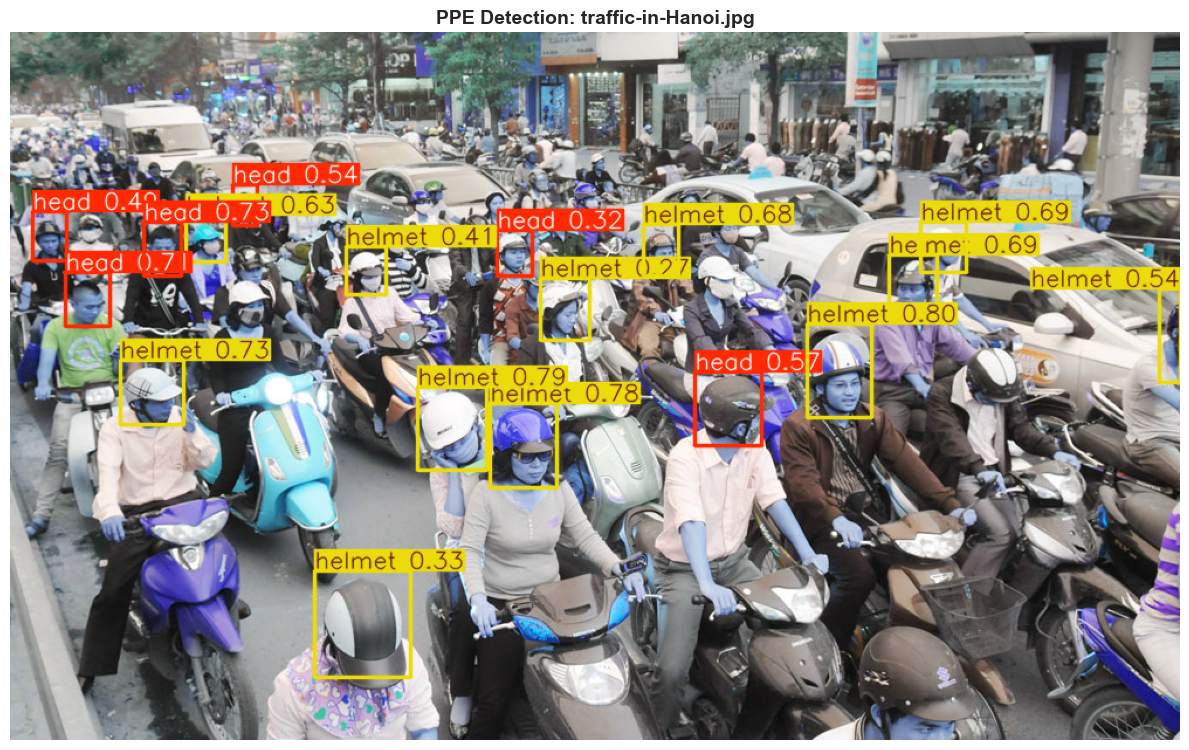


💾 Result saved to: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\single_image_prediction


In [11]:
# Single Image Prediction
# Predict on a specific image file

if model is not None:
    # Path to the image
    image_path = r"C:\Users\Omar\Downloads\traffic-in-Hanoi.jpg"
    
    # Check if image exists
    if os.path.exists(image_path):
        print(f"\n🔍 Running prediction on: {Path(image_path).name}")
        print(f"   Full path: {image_path}")
        
        # Run prediction
        result = model.predict(
            source=image_path,
            imgsz=640,
            conf=0.25,
            iou=0.45,
            device=device,
            half=torch.cuda.is_available(),  # Use FP16 on GPU to save memory
            verbose=True,
            save=True,
            project=str(RUNS_DIR),
            name='single_image_prediction',
            exist_ok=True,
        )
        
        # Display the result
        print(f"\n✅ Prediction complete!")
        
        # Show detection details
        if result[0].boxes is not None and len(result[0].boxes) > 0:
            print(f"\n📊 Detections found: {len(result[0].boxes)}")
            for i in range(len(result[0].boxes)):
                cls_id = int(result[0].boxes.cls[i])
                conf = float(result[0].boxes.conf[i])
                cls_name = class_names[cls_id] if cls_id < len(class_names) else f"class_{cls_id}"
                print(f"   {cls_name}: {conf:.2%} confidence")
        else:
            print("\n⚠️  No detections found in this image")
        
        # Visualize the result
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(result[0].plot())
        ax.set_title(f"PPE Detection: {Path(image_path).name}", fontsize=14, fontweight='bold')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"\n💾 Result saved to: {RUNS_DIR / 'single_image_prediction'}")
    else:
        print(f"\n⚠️  Image not found: {image_path}")
        print("   Please check the file path and try again.")
else:
    print("\n⚠️  Model not loaded. Cannot run prediction.")


In [2]:
# Process test images
if model is None:
    print("⚠️  Cannot proceed without a trained model")
else:
    # Get all test images
    IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    
    if DATA_TEST.exists():
        test_images = [f for f in DATA_TEST.glob('*') if f.suffix.lower() in IMAGE_EXTS]
        test_images = sorted(test_images)
        
        print(f"\n📊 Found {len(test_images)} test images")
        
        if len(test_images) == 0:
            print("⚠️  No test images found in test directory")
        else:
            print(f"✅ Ready to process {len(test_images)} images")
    else:
        print(f"⚠️  Test directory not found: {DATA_TEST}")
        test_images = []



📊 Found 706 test images
✅ Ready to process 706 images


In [4]:
# Run predictions on test set (memory-efficient batch processing)
if model is not None and len(test_images) > 0:
    print(f"\n🔍 Running predictions on test set...")
    print(f"   Confidence threshold: 0.25")
    print(f"   IOU threshold: 0.45")
    print(f"   Processing in batches to reduce memory usage...")
    
    # Process in smaller batches to reduce memory usage
    batch_size = 10  # Process 10 images at a time
    pred_results = []
    total_images = len(test_images)
    
    # Use half precision for GPU to save memory
    use_half = torch.cuda.is_available()
    
    for i in range(0, total_images, batch_size):
        batch_images = test_images[i:i+batch_size]
        batch_num = (i // batch_size) + 1
        total_batches = (total_images + batch_size - 1) // batch_size
        
        print(f"\n   Processing batch {batch_num}/{total_batches} ({len(batch_images)} images)...")
        
        # Run predictions on batch
        batch_results = model.predict(
            source=[str(p) for p in batch_images],
            imgsz=640,
            conf=0.25,
            iou=0.45,
            device=device,
            half=use_half,  # Use FP16 on GPU to save memory
            verbose=False,  # Less verbose for batch processing
            save=True,
            project=str(RUNS_DIR),
            name='ppe_test_predictions',
            exist_ok=True,
        )
        
        pred_results.extend(batch_results)
        
        # Clear GPU cache between batches to free memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        print(f"   ✅ Batch {batch_num} complete ({len(batch_results)} images processed)")
    
    print(f"\n✅ All predictions complete!")
    print(f"   Total images processed: {len(pred_results)}")
    print(f"   Results saved to: {RUNS_DIR / 'ppe_test_predictions'}")
else:
    print("⚠️  Cannot run predictions - model or test images not available")
    pred_results = []



🔍 Running predictions on test set...
   Confidence threshold: 0.25
   IOU threshold: 0.45
   Processing in batches to reduce memory usage...

   Processing batch 1/71 (10 images)...
Results saved to C:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\ppe_test_predictions
   ✅ Batch 1 complete (10 images processed)

   Processing batch 2/71 (10 images)...
Results saved to C:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\ppe_test_predictions
   ✅ Batch 2 complete (10 images processed)

   Processing batch 3/71 (10 images)...
Results saved to C:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\ppe_test_predictions
   ✅ Batch 3 complete (10 images processed)

   Processing batch 4/71 (10 images)...
Results saved to C:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\ppe_test_predictions
   ✅ Batch 4 complete (10 images processed)

   Processing bat

In [4]:
# Visualize sample predictions
if len(pred_results) > 0:
    num_samples = min(12, len(pred_results))
    sample_indices = random.sample(range(len(pred_results)), num_samples)
    
    print(f"\n📊 Visualizing {num_samples} sample predictions...")
    
    cols = 4
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, sample_idx in enumerate(sample_indices):
        ax = axes[idx]
        result = pred_results[sample_idx]
        ax.imshow(result.plot())
        ax.set_title(f"{Path(test_images[sample_idx]).name}", fontsize=9)
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualization complete!")
else:
    print("⚠️  No predictions to visualize")


NameError: name 'pred_results' is not defined

In [6]:
# Statistics and analysis
if len(pred_results) > 0:
    from collections import Counter
    
    class_counts = Counter()
    total_detections = 0
    images_with_detections = 0
    
    for result in pred_results:
        if result.boxes is not None and len(result.boxes) > 0:
            images_with_detections += 1
            for i in range(len(result.boxes)):
                cls_id = int(result.boxes.cls[i])
                cls_name = class_names[cls_id] if cls_id < len(class_names) else f"class_{cls_id}"
                class_counts[cls_name] += 1
                total_detections += 1
    
    print("\n" + "=" * 70)
    print("PREDICTION STATISTICS - Hard Hat / PPE Detection")
    print("=" * 70)
    print(f"\n📊 Overall Statistics:")
    print(f"  Total images processed:    {len(pred_results)}")
    print(f"  Images with detections:     {images_with_detections}")
    print(f"  Total detections:           {total_detections}")
    print(f"  Average detections/image:    {total_detections/len(pred_results):.2f}")
    
    if total_detections > 0:
        print(f"\n📦 Class Distribution:")
        for cls_name in class_names:
            count = class_counts.get(cls_name, 0)
            pct = (count / total_detections * 100) if total_detections > 0 else 0
            print(f"  {cls_name:10s}: {count:6d} ({pct:5.1f}%)")
    
    print("\n" + "=" * 70)
else:
    print("⚠️  No predictions to analyze")



PREDICTION STATISTICS - Hard Hat / PPE Detection

📊 Overall Statistics:
  Total images processed:    706
  Images with detections:     702
  Total detections:           2767
  Average detections/image:    3.92

📦 Class Distribution:
  head      :    780 ( 28.2%)
  helmet    :   1987 ( 71.8%)
  person    :      0 (  0.0%)



In [7]:
# Summary
print("\n" + "=" * 70)
print("PREDICTION SUMMARY - Hard Hat / PPE Detection")
print("=" * 70)
print(f"\n✅ Predictions completed successfully!")
print(f"\n📁 Results saved to: {RUNS_DIR / 'ppe_test_predictions'}")
print(f"\n💡 Next steps:")
print(f"   1. Review prediction results in the saved directory")
print(f"   2. Analyze model performance on test set")
print(f"   3. Fine-tune model if needed based on results")
print(f"   4. Deploy model for production use")
print("=" * 70)



PREDICTION SUMMARY - Hard Hat / PPE Detection

✅ Predictions completed successfully!

📁 Results saved to: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\ppe_test_predictions

💡 Next steps:
   1. Review prediction results in the saved directory
   2. Analyze model performance on test set
   3. Fine-tune model if needed based on results
   4. Deploy model for production use


In [6]:
# Real-Time Video Inference with GPU Acceleration
# High FPS real-time PPE detection on video using CUDA

import cv2
import time
import numpy as np

if model is not None:
    # Video path
    video_path = r"C:\Users\Omar\Downloads\Process of Constructing a Concrete Modular House in Just 2 Weeks. PC(Precast Concrete) Factory..mp4"
    
    # Check if video exists
    if not os.path.exists(video_path):
        print(f"⚠️  Video not found: {video_path}")
        print("   Please check the file path.")
    else:
        print(f"\n🎥 Starting real-time video inference...")
        print(f"   Video: {Path(video_path).name}")
        print(f"   Device: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")
        print(f"   Model: {PPE_MODEL_PATH.name if PPE_MODEL_PATH else 'N/A'}")
        
        # Open video
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print("❌ Error: Could not open video file")
        else:
            # Get video properties
            fps_original = cap.get(cv2.CAP_PROP_FPS)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            print(f"\n📹 Video Properties:")
            print(f"   Resolution: {width}x{height}")
            print(f"   Original FPS: {fps_original:.2f}")
            print(f"   Total frames: {total_frames}")
            
            # Create window
            window_name = "PPE Detection - Real-Time (Press 'q' to quit)"
            cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
            cv2.resizeWindow(window_name, 1280, 720)
            
            # FPS tracking
            fps_counter = 0
            fps_start_time = time.time()
            fps_display = 0.0
            
            # Frame skip for faster processing (process every Nth frame, display all)
            frame_skip = 1  # Set to 2 to process every other frame for even higher FPS
            
            print(f"\n🚀 Starting inference... (Press 'q' to quit)")
            print("=" * 70)
            
            frame_count = 0
            try:
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        print("\n✅ Video playback complete!")
                        break
                    
                    frame_count += 1
                    
                    # Skip frames if needed for higher FPS
                    if frame_count % frame_skip != 0:
                        continue
                    
                    # Run inference on GPU with optimized settings
                    start_time = time.time()
                    
                    results = model.predict(
                        source=frame,
                        imgsz=640,
                        conf=0.25,
                        iou=0.45,
                        device=device,  # GPU/CUDA
                        half=True if torch.cuda.is_available() else False,  # FP16 for speed
                        verbose=False,  # No verbose output for speed
                        stream=False,   # Process frame immediately
                    )
                    
                    inference_time = time.time() - start_time
                    
                    # Draw results on frame
                    annotated_frame = results[0].plot()
                    
                    # Calculate and display FPS
                    fps_counter += 1
                    if fps_counter % 10 == 0:  # Update FPS every 10 frames
                        elapsed = time.time() - fps_start_time
                        fps_display = 10.0 / elapsed if elapsed > 0 else 0
                        fps_start_time = time.time()
                    
                    # Add FPS and info overlay
                    cv2.putText(annotated_frame, 
                               f"FPS: {fps_display:.1f} | Inference: {inference_time*1000:.1f}ms",
                               (10, 30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 
                               0.7, 
                               (0, 255, 0), 
                               2)
                    
                    # Add detection count
                    if results[0].boxes is not None:
                        num_detections = len(results[0].boxes)
                        cv2.putText(annotated_frame,
                                   f"Detections: {num_detections}",
                                   (10, 60),
                                   cv2.FONT_HERSHEY_SIMPLEX,
                                   0.7,
                                   (0, 255, 255),
                                   2)
                    
                    # Display frame
                    cv2.imshow(window_name, annotated_frame)
                    
                    # Check for quit
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        print("\n⚠️  Stopped by user (q pressed)")
                        break
                    
                    # Print progress every 100 frames
                    if frame_count % 100 == 0:
                        progress = (frame_count / total_frames * 100) if total_frames > 0 else 0
                        print(f"   Processed {frame_count}/{total_frames} frames ({progress:.1f}%) | FPS: {fps_display:.1f}")
            
            except KeyboardInterrupt:
                print("\n⚠️  Interrupted by user")
            finally:
                # Cleanup
                cap.release()
                cv2.destroyAllWindows()
                
                # Clear GPU cache
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                print("\n" + "=" * 70)
                print("✅ Video inference complete!")
                print(f"   Total frames processed: {frame_count}")
                print(f"   Average FPS: {fps_display:.1f}")
                print("=" * 70)
else:
    print("\n⚠️  Model not loaded. Cannot run video inference.")
    print("   Please ensure the model is loaded in the first cell.")



🎥 Starting real-time video inference...
   Video: Process of Constructing a Concrete Modular House in Just 2 Weeks. PC(Precast Concrete) Factory..mp4
   Device: GPU (CUDA)
   Model: best.pt

📹 Video Properties:
   Resolution: 1280x720
   Original FPS: 59.94
   Total frames: 108405

🚀 Starting inference... (Press 'q' to quit)
   Processed 100/108405 frames (0.1%) | FPS: 37.7
   Processed 200/108405 frames (0.2%) | FPS: 31.5
   Processed 300/108405 frames (0.3%) | FPS: 38.6
   Processed 400/108405 frames (0.4%) | FPS: 28.3
   Processed 500/108405 frames (0.5%) | FPS: 30.4
   Processed 600/108405 frames (0.6%) | FPS: 30.3

⚠️  Stopped by user (q pressed)

✅ Video inference complete!
   Total frames processed: 699
   Average FPS: 29.4
